# Character Recognition

Eksperimen yang dilakukan adalah melakuakn kombinasi antara CTPN dan Tesseract. CTPN digunakan untuk mendapatkan bounding box yang berisi prediksi posisi text. Tesseract berfungsi sebagai character recognizer. Sebelum gambar diolah Tesseract, dilakukan preproses terlebhi dahulu agar meningkatkan akurasi. Ide eksperimen ini mirip dengan ide Faster RCNN yang terdiri dari RPN dan Fast-CNN.

## CTPN

sumber inspirasi: 
- https://arxiv.org/abs/1609.03605
- https://github.com/eragonruan/text-detection-ctpn

In [1]:
from __future__ import print_function

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

from lib.fast_rcnn.config import cfg, cfg_from_file
from lib.fast_rcnn.test import _get_blobs
from lib.text_connector.detectors import TextDetector
from lib.text_connector.text_connect_cfg import Config as TextLineCfg
from lib.rpn_msr.proposal_layer_tf import proposal_layer

def resize_im(im, scale, max_scale=None):
    f = float(scale) / min(im.shape[0], im.shape[1])
    if max_scale != None and f * max(im.shape[0], im.shape[1]) > max_scale:
        f = float(max_scale) / max(im.shape[0], im.shape[1])
    return cv2.resize(im, None, None, fx=f, fy=f, interpolation=cv2.INTER_LINEAR), f


def draw_boxes(img, image_name, boxes, scale, bbox):
    for box in boxes:
        if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3] - box[0]) < 5:
            continue
        if box[8] >= 0.9:
            color = (0, 255, 0)
        elif box[8] >= 0.8:
            color = (255, 0, 0)
        cv2.line(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
        cv2.line(img, (int(box[0]), int(box[1])), (int(box[4]), int(box[5])), color, 2)
        cv2.line(img, (int(box[6]), int(box[7])), (int(box[2]), int(box[3])), color, 2)
        cv2.line(img, (int(box[4]), int(box[5])), (int(box[6]), int(box[7])), color, 2)

        min_x = min(int(box[0] / scale), int(box[2] / scale), int(box[4] / scale), int(box[6] / scale))
        min_y = min(int(box[1] / scale), int(box[3] / scale), int(box[5] / scale), int(box[7] / scale))
        max_x = max(int(box[0] / scale), int(box[2] / scale), int(box[4] / scale), int(box[6] / scale))
        max_y = max(int(box[1] / scale), int(box[3] / scale), int(box[5] / scale), int(box[7] / scale))
        
        bbox.append([min_x, min_y, max_x, max_y])

    img = cv2.resize(img, None, None, fx=1.0 / scale, fy=1.0 / scale, interpolation=cv2.INTER_LINEAR)

In [2]:
cfg_from_file('ctpn/text.yml')

# init session
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.5
sess = tf.Session(config=config)
with gfile.FastGFile('data/ctpn.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
sess.run(tf.global_variables_initializer())

input_img = sess.graph.get_tensor_by_name('Placeholder:0')
output_cls_prob = sess.graph.get_tensor_by_name('Reshape_2:0')
output_box_pred = sess.graph.get_tensor_by_name('rpn_bbox_pred/Reshape_1:0')

In [3]:
im_name = "data/demo/polo1262.jpg"
img = cv2.imread(im_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, scale = resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
blobs, im_scales = _get_blobs(img, None)
if cfg.TEST.HAS_RPN:
    im_blob = blobs['data']
    blobs['im_info'] = np.array(
        [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
        dtype=np.float32)
cls_prob, box_pred = sess.run([output_cls_prob, output_box_pred], feed_dict={input_img: blobs['data']})
rois, _ = proposal_layer(cls_prob, box_pred, blobs['im_info'], 'TEST', anchor_scales=cfg.ANCHOR_SCALES)

scores = rois[:, 0]
boxes = rois[:, 1:5] / im_scales[0]
textdetector = TextDetector()
boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
bbox = []
draw_boxes(img, im_name, boxes, scale, bbox)

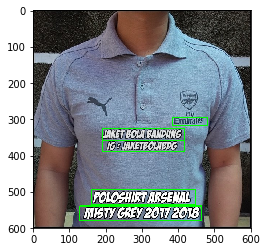

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline  

# draw image
plt.figure()
plt.imshow(img)

# cv2.imwrite("image", img)

### Get Images from Bounding Box

In [5]:
imgs = []
img = cv2.imread(im_name)
for b in bbox :
    y1 = int(b[0]) 
    y2 = int(b[2]) 
    x1 = int(b[1]) 
    x2 = int(b[3]) 
    crop_img = img[x1:x2, y1:y2]
    imgs.append(crop_img)
#     cv2.imwrite(str(x1) + ".jpg", crop_img)

In [6]:
# for i in imgs :
#     plt.figure()
#     plt.imshow(i)

## Tesseract

### Without processing

In [7]:
import tesserocr
from PIL import Image

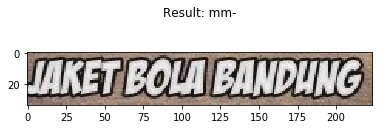

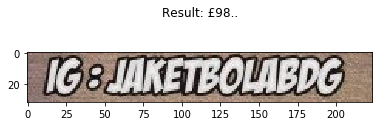

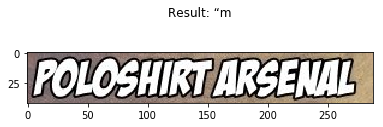

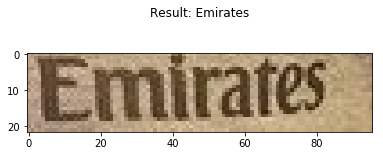

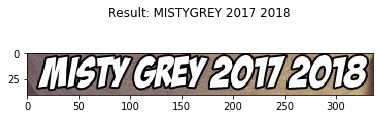

In [8]:
# print(tesserocr.tesseract_version())  # print tesseract-ocr version
# print(tesserocr.get_languages())  # prints tessdata path and list of available languages

texts = []

for img in imgs :
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    img = Image.fromarray(img)
    text = tesserocr.image_to_text(img)  # print ocr text from image
    title = "Result: " + text
    ax1.set_title(title)
    plt.imshow(img)
    texts.append(text)
    


### Resampling

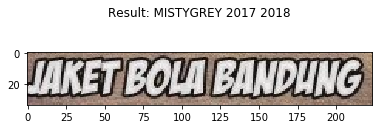

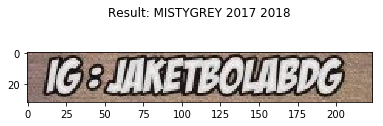

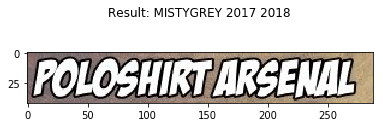

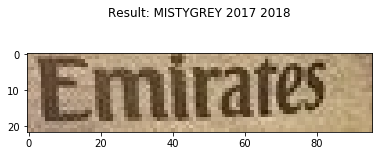

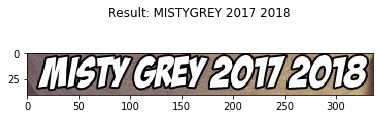

In [9]:
def resampleProcessor(img) :
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img = Image.fromarray(img)
    text = tesserocr.image_to_text(img)  # print ocr text from image
    return text, img

imgs_copy = imgs
for img in imgs_copy :
    title = "Result: " + text
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax1.set_title(title)
    plt.imshow(img)


### Resampling  + Unsharp

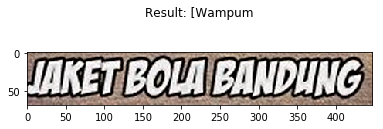

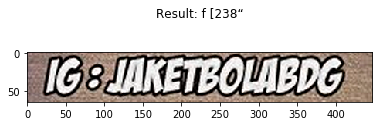

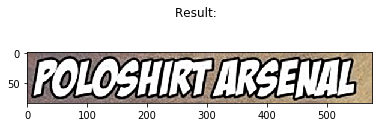

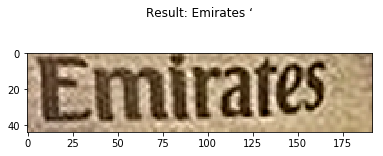

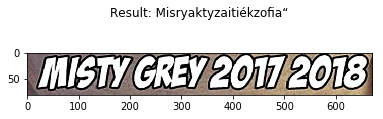

In [10]:
imgs_copy = imgs
for img in imgs_copy :
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    gaussian_3 = cv2.GaussianBlur(img, (9,9), 10.0)
    unsharp_image = cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)
    img = Image.fromarray(img)
    text = tesserocr.image_to_text(img)  # print ocr text from image
    title = "Result: " + text
    ax1.set_title(title)
    plt.imshow(img)


### Otsu Binarization

In [11]:
imgs_copy = imgs
for img in imgs_copy :
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     img = cv2.bitwise_not(img)
    img = Image.fromarray(img)
    text = tesserocr.image_to_text(img)  # print ocr text from image
    title = "Result: " + text
#     fig = plt.figure()
#     ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
#     ax1.set_title(title)
#     plt.imshow(img)

### Median Blur

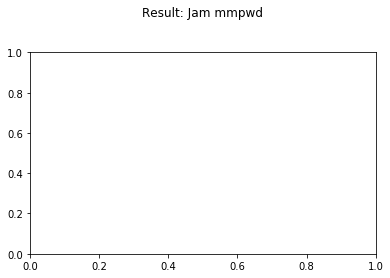

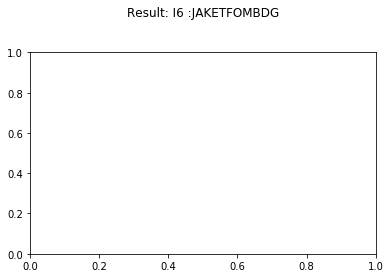

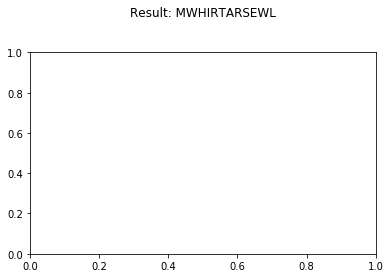

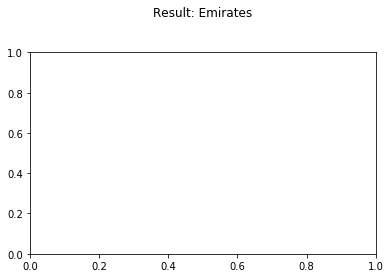

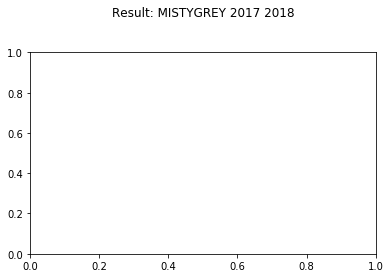

In [12]:
imgs_copy = imgs
for img in imgs_copy :
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     img = cv2.bitwise_not(img)
    img = cv2.medianBlur(img, 5)
    img = Image.fromarray(img)
    text = tesserocr.image_to_text(img)  # print ocr text from image
    title = "Result: " + text
    ax1.set_title(title)
#     plt.imshow(img)

# PyOCR
A Python wrapper for OCR engines (Tesseract, Cuneiform, etc)

## To Do List
- [DONE] nyoba2 beberapa filter untuk kasus kata yang berdekatan. dikasih deskripsi kelebihan dan kekurangan untuk setiap eksperimen
- [DONE] validasi text melalui http request
- [DONE] coba preprocessing dengan mencari blob, jika ada yang lebih dari 1/4 luas box, dihilangkan

In [13]:
import pyocr
import pyocr.builders

tool = pyocr.get_available_tools()[0]
builder = pyocr.builders.TextBuilder()

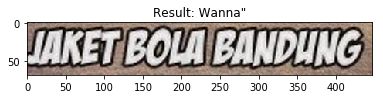

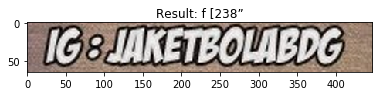

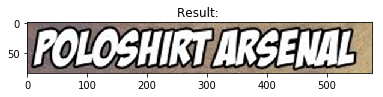

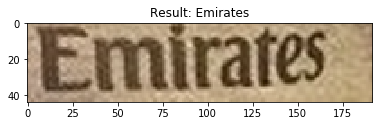

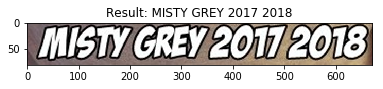

In [14]:
imgs_copy = imgs

for img in imgs_copy :
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img = Image.fromarray(img)
    text = tool.image_to_string(
        img,
        lang='eng',
        builder=builder
    )
    title = "Result: " + text
    ax1.set_title(title)
    plt.imshow(img)


### Binarization

In [15]:
def binarizationProcessor(img) :
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    img = Image.fromarray(img)
    text = tool.image_to_string(
        img,
        lang='eng',
        builder=builder
    )
    return text, img

texts = []
imgs_copy = imgs
# for img in imgs_copy :
#     fig = plt.figure()
#     ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
#     text, img = binarizationProcessor(img)
#     title = "Result: " + text
#     ax1.set_title(title)
#     plt.imshow(img)
    
#     texts.append(text)

In [16]:
def getBackgroundColor(img) :
    height, width = img.shape
    size = 5
    top_left = img[0:size, 0:size]
    top_right = img[0:size, width-size-1:width-1]
    bottom_left = img[height-size-1:height-1, 0:size]
    bottom_right = img[height-size-1:height-1, width-size-1:width-1]
    colors = [np.median(top_left), np.median(top_right), np.median(bottom_left), np.median(bottom_right)]
#     print(colors)
    return int(np.median(colors))

def binarizationProcessor(img) :
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    median = np.median(img)
    back_color = getBackgroundColor(img)
#     print(back_color)
    if back_color == 127 :
        if median == 255 :
            img = cv2.bitwise_not(img)
    elif back_color == 255 :
        img = cv2.bitwise_not(img)
        

    kernel = np.ones((3,3),np.uint8)
    img = cv2.erode(img,kernel,iterations = 1)
#     img = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)
    cv2.imwrite(str(img.shape[0]) + ".jpg", img)
    img = Image.fromarray(img)
    text = tool.image_to_string(
        img,
        lang='eng',
        builder=builder
    )
    return text, img

# texts = []
imgs_copy = imgs
# for img in imgs_copy :
#     text, img = binarizationProcessor(img)
#     title = "Result: " + text
#     fig = plt.figure()
#     ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
#     ax1.set_title(title)
#     plt.imshow(img)
    
#     texts.append(text)

### Blob Preprocessing

PR:
- [DONE] seleksi bentuk blob terbesar yang lonjong. referensi = (https://gurus.pyimagesearch.com/lesson-sample-advanced-contour-properties/)

In [17]:
def blobProcessor(img) :
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img_raw = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img = cv2.bitwise_not(img)
    
    # blob
    median = np.median(img) 
    _, contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    contour_outer = []
    contour_inner = []
    
    if len(contours) > 0 :
        max_idx = 0
        max_area = cv2.contourArea(contours[0])
        max_contour = contours[0]
        for i in range(1, len(contours)):
            area = cv2.contourArea(contours[i])
            if area > max_area :
                max_area = area
                max_idx = i

        (x, y, w, h) = cv2.boundingRect(contours[max_idx])
        ratio = float(w)/float(h)
    #     print(ratio)
        for i in range(0, len(contours)):
            if i == max_idx :
                contour_outer.append(contours[i])
            else :
                contour_inner.append(contours[i])
    #     cv2.drawContours(img_raw, contour_list,  -1, (255,0,0), 2)
        if ratio >= 1 :
            if median == 0 :
                cv2.fillPoly(img, pts=contour_outer, color=(0))
                cv2.fillPoly(img, pts=contour_inner, color=(255))
            else :
                cv2.fillPoly(img, pts=contour_outer, color=(255))
                cv2.fillPoly(img, pts=contour_inner, color=(0))
    
    
    img = Image.fromarray(img)
    text = tool.image_to_string(
        img,
        lang='eng',
        builder=builder
    )
    
    return text, img

texts = []
imgs_copy = imgs
# for img in imgs_copy :
#     text, img = blobProcessor(img)
#     title = "Result: " + text
#     fig = plt.figure()
#     ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
#     ax1.set_title(title)
#     plt.imshow(img)
    
#     plt.imshow(img_raw)
    
#     texts.append(text)

## (SEE) Semi-Supervised End-to-End Scene Text Recognition

In [33]:
import argparse
import importlib

import os

import json
from collections import OrderedDict

import chainer
from pprint import pprint

import chainer.functions as F
import numpy as np

from PIL import Image
from chainer import configuration

from see.chainer.utils.datatypes import Size

from see.chainer import functions


def get_class_and_module(log_data):
    if not isinstance(log_data, list):
        if 'InverseCompositional' in log_data:
            module_name = 'ic_stn.py'
            klass_name = log_data
        else:
            module_name = 'text_recognition.py'
            klass_name = log_data
    else:
        klass_name, module_name = log_data
    return klass_name, module_name


def load_module(module_file):
    module_spec = importlib.util.spec_from_file_location("models.model", module_file)
    module = importlib.util.module_from_spec(module_spec)
    module_spec.loader.exec_module(module)
    return module


def build_recognition_net(recognition_net_class, target_shape, args):
    return recognition_net_class(
        target_shape,
        num_rois=args.timesteps,
        label_size=52,
    )


def build_localization_net(localization_net_class, target_shape, args):
    return localization_net_class(
        args.dropout_ratio,
        args.timesteps,
        0,
        target_shape,
        zoom=1.0,
        do_parameter_refinement=False
    )


def build_fusion_net(fusion_net_class, localization_net, recognition_net):
    return fusion_net_class(localization_net, recognition_net)


def create_network(args, log_data):
    # Step 1: build network
    localization_net_class_name, localization_module_name = get_class_and_module(log_data['localization_net'])
    module = load_module(os.path.abspath(os.path.join(args.model_dir, localization_module_name)))
    localization_net_class = eval('module.{}'.format(localization_net_class_name))
    localization_net = build_localization_net(localization_net_class, log_data['target_size'], args)

    recognition_net_class_name, recognition_module_name = get_class_and_module(log_data['recognition_net'])
    module = load_module(os.path.abspath(os.path.join(args.model_dir, recognition_module_name)))
    recognition_net_class = eval('module.{}'.format(recognition_net_class_name))
    recognition_net = build_recognition_net(recognition_net_class, target_shape, args)

    fusion_net_class_name, fusion_module_name = get_class_and_module(log_data['fusion_net'])
    module = load_module(os.path.abspath(os.path.join(args.model_dir, fusion_module_name)))
    fusion_net_class = eval('module.{}'.format(fusion_net_class_name))
    net = build_fusion_net(fusion_net_class, localization_net, recognition_net)

    if args.gpu >= 0:
        net.to_gpu(args.gpu)

    return net


def load_image(image_file, xp, image_size):
    with Image.open(image_file) as the_image:
        the_image = the_image.convert('L')
        the_image = the_image.resize((image_size.width, image_size.height), Image.LANCZOS)
        image = xp.asarray(the_image, dtype=np.float32)
        image /= 255
        image = xp.broadcast_to(image, (3, image_size.height, image_size.width))
        return image

def preprocess_image(the_image, xp, image_size) :
    the_image = the_image.convert('L')
    the_image = the_image.resize((image_size.width, image_size.height), Image.LANCZOS)
    image = xp.asarray(the_image, dtype=np.float32)
    image /= 255
    image = xp.broadcast_to(image, (3, image_size.height, image_size.width))
    return image

def strip_prediction(predictions, xp, blank_symbol):
    words = []
    for prediction in predictions:
        blank_symbol_seen = False
        stripped_prediction = xp.full((1,), prediction[0], dtype=xp.int32)
        for char in prediction:
            if char == blank_symbol:
                blank_symbol_seen = True
                continue
            if char == stripped_prediction[-1] and not blank_symbol_seen:
                continue
            blank_symbol_seen = False
            stripped_prediction = xp.hstack((stripped_prediction, char.reshape(1, )))
        words.append(stripped_prediction)
    return words


def extract_bbox(bbox, image_size, target_shape, xp):
    bbox.data[...] = (bbox.data[...] + 1) / 2
    bbox.data[0, :] *= image_size.width
    bbox.data[1, :] *= image_size.height

    x = xp.clip(bbox.data[0, :].reshape(target_shape), 0, image_size.width)
    y = xp.clip(bbox.data[1, :].reshape(target_shape), 0, image_size.height)

    top_left = (float(x[0, 0]), float(y[0, 0]))
    bottom_right = (float(x[-1, -1]), float(y[-1, -1]))

    return top_left, bottom_right

In [34]:
args = argparse.ArgumentParser(description="Tool that loads model and predicts on a given image")
args.model_dir = "see/chainer/text_recognition_model/model"
args.snapshot_name = "model_190000.npz"
args.image_path = "data/demo/polo1262.jpg"
args.char_map = "see/chainer/text_recognition_model/small_dataset/ctc_char_map.json"
args.log_name = 'log'
args.dropout_ratio = 0.5
args.blank_symbol = 0
args.gpu = 0
# max number of text regions in the image
args.timesteps = 23
# max number of characters per word
args.num_labels = 1

# open log and extract meta information
with open(os.path.join(args.model_dir, args.log_name)) as the_log:
    log_data = json.load(the_log)[0]

target_shape = Size._make(log_data['target_size'])
image_size = Size._make(log_data['image_size'])

xp = chainer.cuda.cupy if args.gpu >= 0 else np
network = create_network(args, log_data)

# load weights
with np.load(os.path.join(args.model_dir, args.snapshot_name)) as f:
    chainer.serializers.NpzDeserializer(f).load(network)

# load char map
with open(args.char_map) as the_map:
    char_map = json.load(the_map)

# load image
image = load_image(args.image_path, xp, image_size)
with configuration.using_config('train', False):
    predictions, crops, grids = network(image[xp.newaxis, ...])

# extract class scores for each word
words = OrderedDict({})

predictions = F.concat([F.expand_dims(prediction, axis=0) for prediction in predictions], axis=0)

classification = F.softmax(predictions, axis=2)
classification = classification.data
classification = xp.argmax(classification, axis=2)
classification = xp.transpose(classification, (1, 0))

word = strip_prediction(classification, xp, args.blank_symbol)[0]

word = "".join(map(lambda x: chr(char_map[str(x)]), word))

print(word)

def predict_see(image) :
    image = preprocess_image(image, xp, image_size)
    with configuration.using_config('train', False):
        predictions, crops, grids = network(image[xp.newaxis, ...])

    predictions = F.concat([F.expand_dims(prediction, axis=0) for prediction in predictions], axis=0)

    classification = F.softmax(predictions, axis=2)
    classification = classification.data
    classification = xp.argmax(classification, axis=2)
    classification = xp.transpose(classification, (1, 0))

    word = strip_prediction(classification, xp, args.blank_symbol)[0]

    word = "".join(map(lambda x: chr(char_map[str(x)]), word))

    return word

# bboxes = []
# for bbox in grids[0]:
#     bbox = extract_bbox(bbox, image_size, target_shape, xp)
#     bboxes.append(OrderedDict({
#         'top_left': bbox[0],
#         'bottom_right': bbox[1]
#     }))
# words[word] = bboxes

# # pprint(words)
# for k, v in words.items() :
#     print(k)

teme


## Comparation between SEE and Tesseract

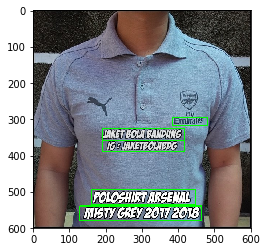

In [35]:
im_name = "data/demo/polo1262.jpg"
img = cv2.imread(im_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, scale = resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
blobs, im_scales = _get_blobs(img, None)
if cfg.TEST.HAS_RPN:
    im_blob = blobs['data']
    blobs['im_info'] = np.array(
        [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
        dtype=np.float32)
cls_prob, box_pred = sess.run([output_cls_prob, output_box_pred], feed_dict={input_img: blobs['data']})
rois, _ = proposal_layer(cls_prob, box_pred, blobs['im_info'], 'TEST', anchor_scales=cfg.ANCHOR_SCALES)

scores = rois[:, 0]
boxes = rois[:, 1:5] / im_scales[0]
textdetector = TextDetector()
boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
bbox = []
draw_boxes(img, im_name, boxes, scale, bbox)

import matplotlib.pyplot as plt
%matplotlib inline  

# draw image
plt.figure()
plt.imshow(img)

# cv2.imwrite("image", img)

In [37]:
imgs = []
img = cv2.imread(im_name)
for b in bbox :
    y1 = int(b[0]) 
    y2 = int(b[2]) 
    x1 = int(b[1]) 
    x2 = int(b[3]) 
    crop_img = img[x1:x2, y1:y2]
    i = Image.fromarray(crop_img)
    print(predict_see(i))
    imgs.append(crop_img)
    

iarebobandig
igeimatoeng
poloskitsein
emirates
misty grezotzo


# Information Extraction

Pada tahap ini dilakukan eksperimen untuk mengetahui apakah di dalam text yang ada terdapat informasi seperti kontak HP, id bbm, id line, dll.

### Kontak HP

Deteksi dilakukan menggunakan regex

In [26]:
import re

def isContainHP(text) :
    # preprocess
    # remove some symbol
    text = text.translate('-\'.() !@#')
    print(text)
    result = re.match("[0]\d{9,11}|[+]\d{12,14}", text)
    if result :
        print(result.group(0))
        return True
    else :
        return False

text = "09342.31.32.33"
print(isContainHP(text))

09342.31.32.33
False


### Validasi melalui akun media sosial

#### Twitter

In [26]:
import urllib2

def isValidUserTwitter(username) :

    url = "https://twitter.com/" + username
    try: 
        status = urllib2.urlopen(url).getcode()
    except urllib2.HTTPError as err:
        if err.code == 404:
    #         print("No User Found")
            status = 404
        else:
            raise
    return status == 200


username = "mhilmiasyrofi"
print(isValidUserTwitter(username))

True


#### Instagram

In [27]:
def isValidUserInstagram(username) :
    url = "https://www.instagram.com/" + username + "/"
    try: 
        status = urllib2.urlopen(url).getcode()
    except urllib2.HTTPError as err:
        if err.code == 404:
    #         print("No User Found")
            status = 404
        else:
            raise
    return status == 200
    
username = "avnusavas"
print(isValidUserInstagram(username))

False


# Eksperimen Dengan Banyak Gambar

[NOTE] ada sekitar 21000, dibutuhkan waktu yang lama

In [ ]:
import glob
import os
import shutil
import sys

# import list of images
im_names = glob.glob(os.path.join(cfg.DATA_DIR, 'fashion_bl/', '*/*.png')) \
        + glob.glob(os.path.join(cfg.DATA_DIR, 'fashion_bl/', '*/*.jpg'))

results_sample = []
for im_name in im_names:
    img = cv2.imread(im_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_copy = img
    img, scale = resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
    blobs, im_scales = _get_blobs(img, None)
    if cfg.TEST.HAS_RPN:
        im_blob = blobs['data']
        blobs['im_info'] = np.array(
            [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
            dtype=np.float32)
    cls_prob, box_pred = sess.run([output_cls_prob, output_box_pred], feed_dict={input_img: blobs['data']})
    rois, _ = proposal_layer(cls_prob, box_pred, blobs['im_info'], 'TEST', anchor_scales=cfg.ANCHOR_SCALES)

    scores = rois[:, 0]
    boxes = rois[:, 1:5] / im_scales[0]
    textdetector = TextDetector()
    boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
    bbox = []
    draw_boxes(img, im_name, boxes, scale, bbox)

    texts = []
    imgs = []

    for b in bbox :
        y1 = int(b[0]) 
        y2 = int(b[2]) 
        x1 = int(b[1]) 
        x2 = int(b[3]) 
        crop_img = img[x1:x2, y1:y2]
        imgs.append(crop_img)

    for img in imgs :
        text, img = binarizationProcessor(img)
        if text != "" :
            texts.append(text)
#                 if text[0] == '@' :
#                     text = text[1:len(text)]
#                     if isValidUserTwitter(text) or isValidUserInstagram(text) :
#                         results.append({"Image" : img, "Text" : text, "Name" : im_name})
#                 elif isContainHP(text) :
#                     results.append({"Image" : img, "Text" : text, "Name" : im_name})
    results_sample.append(texts)


In [ ]:
print(results_sample)